<a href="https://colab.research.google.com/github/Xantanio/myProjects/blob/main/trabalho_final_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicação de Redes Neurais Convolucionais (CNN) em um problema de classificação binária ou com múltiplas classes.**

## **Inicialização**

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


O dataset escolhido foi o [Classificação de pacientes com pneumonia utilizando imagens de raio-x.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

In [ ]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

# Diretórios do dataset
train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

In [ ]:
PNEUMONIA = os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA")
NORMAL = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")
len(PNEUMONIA) + len(NORMAL)

5216

## **Exemplos das imagens para cada diretório**

In [ ]:
def plot_images(dirr, folder):
    plt.figure(figsize=(20,10))
    for index, img in enumerate(random.sample(dirr, 6)):
        plt.subplot(230 + index + 1)
        img_rgb = cv2.cvtColor(cv2.imread(os.path.join(train_dir, folder, img)), cv2.COLOR_BGR2GRAY)
        plt.imshow(img_rgb, cmap='gray')

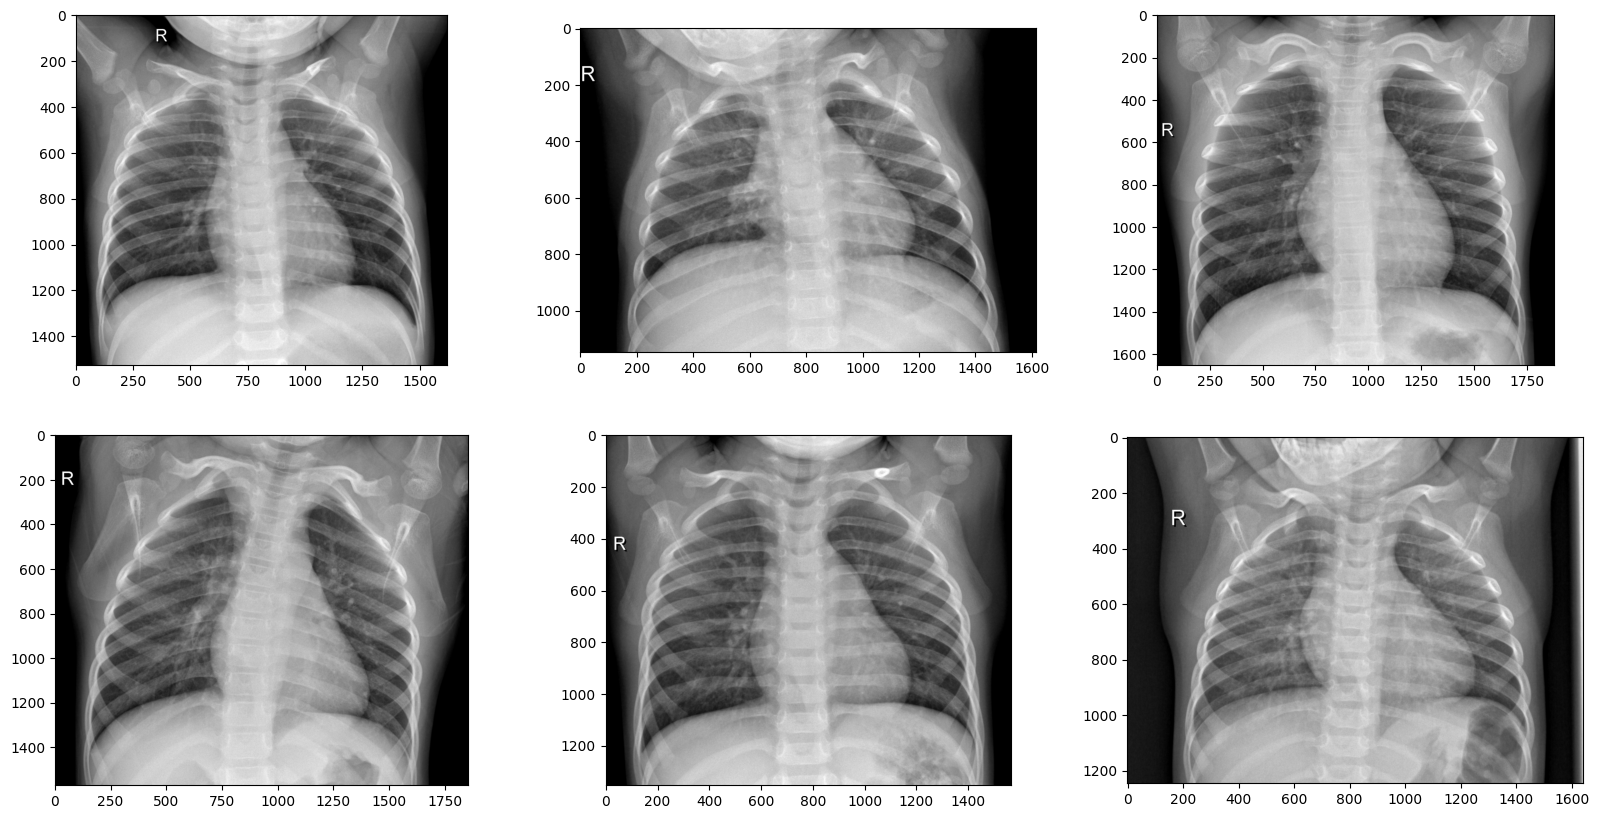

In [ ]:
plot_images(NORMAL, "NORMAL")

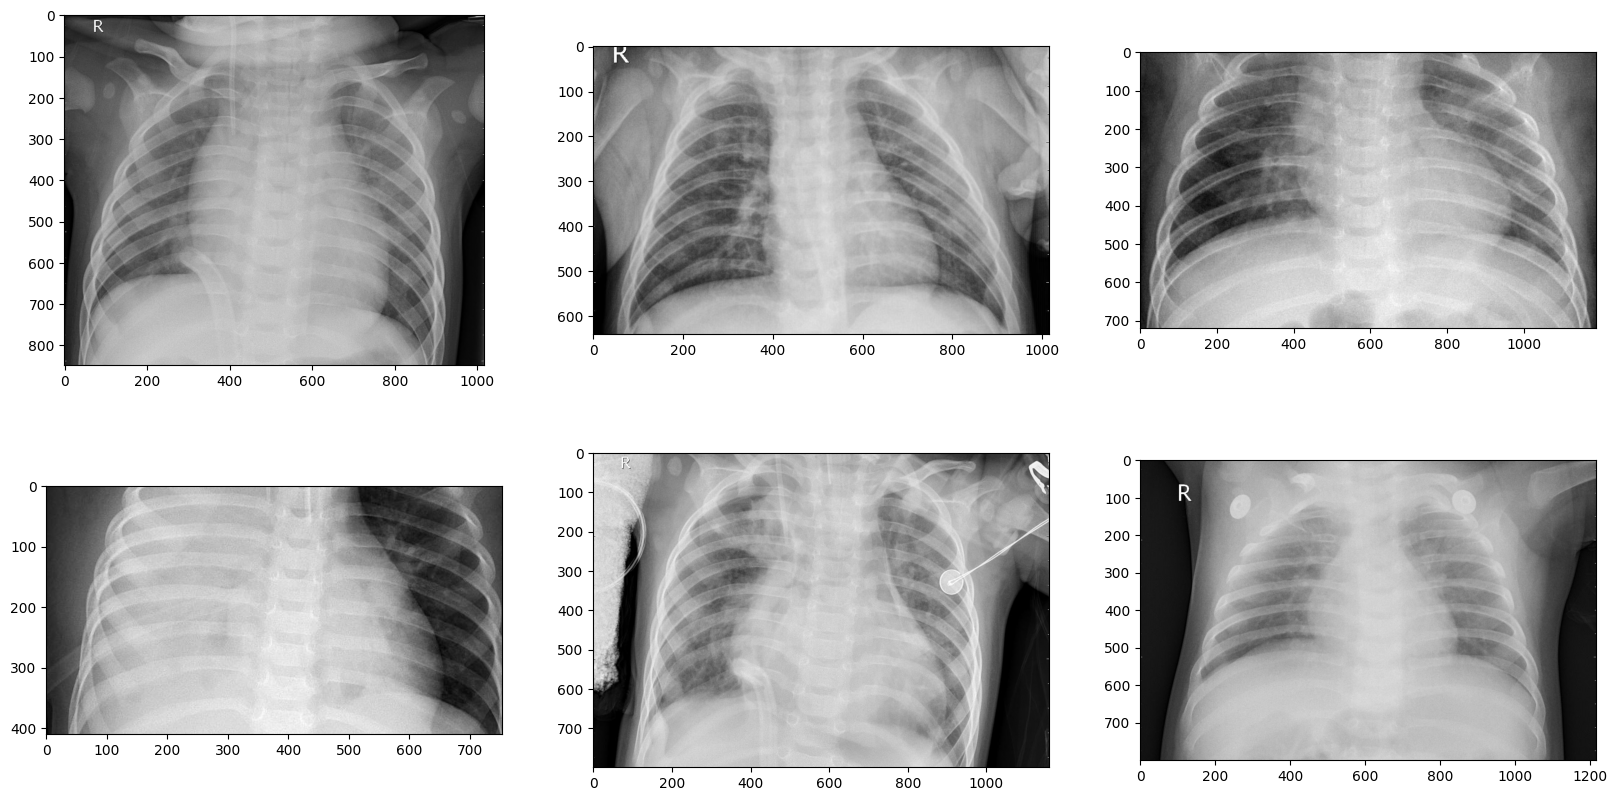

In [ ]:
plot_images(PNEUMONIA, "PNEUMONIA")

Quantidade de Imagens para cada 'classe'

In [ ]:
len(PNEUMONIA), len(NORMAL)

(3875, 1341)

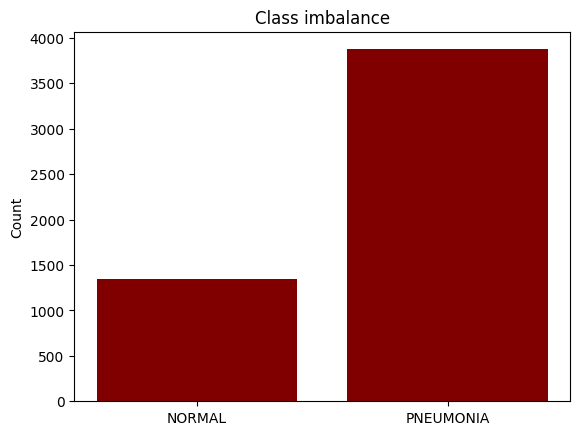

In [ ]:
counts = {"NORMAL": len(NORMAL), "PNEUMONIA": len(PNEUMONIA)}
plt.bar(list(counts.keys()), list(counts.values()), color ='maroon')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Class imbalance')
plt.show()

In [ ]:
bias = np.log([len(PNEUMONIA)/len(NORMAL)])
bias
#e^1.06=2.89

2.889634601043997

Atribuiremos novos pesos para contrabalançar as classes de desequilíbrio.

In [ ]:
class_0 = 5216/(2*1342)
class_1 = 5216/(2*3876)
class_weights = {0: class_0, 1: class_1}

print('Class 0: {:.2f}'.format(class_0))
print('Class 1: {:.2f}'.format(class_1))

Class 0: 1.94
Class 1: 0.67


## **Construindo CNN**

In [ ]:
batch_size = 64
img_height = 150
img_width = 150

train_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  #imagens de treinamento e seus rótulos, organizados em lotes de 64 imagens.

test_data = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  #imagens de teste e seus rótulos, organizados em lotes de 64 imagens.

val_data = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  #imagens de validação e seus rótulos, organizados em lotes de 64 imagens.

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
train_data.class_names

['NORMAL', 'PNEUMONIA']

## **Criação e Treinamento do Modelo**

### Criação do modelo sequencial

In [ ]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Rescaling, BatchNormalization
from keras._tf_keras.keras.regularizers import l2

cnn_model = Sequential(
        [
            # Normaliza os valores de pixel da imagem
            Rescaling(1/255),

            # Cria camada convulacional de 32 filtros 3x3, acelera treinamento e regulariza valores grandes
            Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.0001)),
            # 23 filtros 3x3 e acelera treinamento
            Conv2D(32, 3, activation='relu'),
            # Normaliza a saida dos dados
            BatchNormalization(),
            # Reduz a resolução das camadas anteriores, abstrai caracteristicas
            MaxPooling2D(),
            # Desativa parte dos neurônios, evita overfitting
            Dropout(0.2),

            # Mais uma camada convulacional com 64 filtros 3x3, acelera treinamento e regulariza valores grandes
            Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.0001)),
            # Reduz a resolução novamente para abstrair caracteristicas
            MaxPooling2D(),
            # Desativa outra parte aleatoria dos neuronios
            Dropout(0.2),

            # Mais uma camada convulacional com 128 filtros 3x3
            Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.0001)),
            # Reduz mais ainda a resolução
            MaxPooling2D(),
            # Desativa outros 20% dos neuronios
            Dropout(0.2),

            # O número de filtros aumenta conforme a rede avança
            Conv2D(256, 3, activation='relu', kernel_regularizer=l2(0.0001)),
            MaxPooling2D(),
            Dropout(0.2),

            # Transforma em um vetor unitario
            Flatten(),
            # Camada densa de 64 neuronios
            Dense(units=64, activation='relu'),
            # Desativa metade dos neuronios, agressivamente evita overfitting
            Dropout(0.5),
            # Ultima camada densa, dessa vez probabilidade entre 0 e 1.
            Dense(units=1, activation='sigmoid')

        ]
        )

### Configuração do Callback

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Interrompe o treinamento se o modelo não melhorar com um certo número de epocas
early_stopping_cb = EarlyStopping(
  monitor='val_loss', # Acompanha perda de validação
  min_delta=0.0001, # Melhora minima de val_loss
  verbose=1, # Printar log
  patience=5, # Espera até 5 epocas
  restore_best_weights=True # Salva os melhores pesos
  )

### Compilação do Modelo

In [ ]:
# Configura o modelo, suas metricas, funções de perda e otimizadores
cnn_model.compile(
    loss='binary_crossentropy', # Função de perda para resultado binario
    optimizer=Adam(learning_rate=0.0001, beta_1=0.92, beta_2=0.999), # Otimizador, ajuda a taxa de aprendizado de forma adaptativa
    metrics=[ # Metricas que o modelo acompanha
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    )

### Treinamento

In [ ]:
# Treina o modelo
cnn_model_hist = cnn_model.fit(
    train_data, # dados para treinar
    epochs=5, # epocas
    class_weight=class_weights, # balanceia o peso das classes
    validation_data=test_data, # dados para teste
    callbacks=[early_stopping_cb] # callback utilizado
    )

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.6778 - loss: 0.5780 - precision: 0.8825 - recall: 0.6426 - val_accuracy: 0.6234 - val_loss: 0.6728 - val_precision: 0.6244 - val_recall: 0.9974
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 400s 5s/step - accuracy: 0.9170 - loss: 0.2349 - precision: 0.9734 - recall: 0.9125 - val_accuracy: 0.6587 - val_loss: 0.6331 - val_precision: 0.6473 - val_recall: 0.9974
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.9434 - loss: 0.1933 - precision: 0.9781 - recall: 0.9441 - val_accuracy: 0.6490 - val_loss: 0.5989 - val_precision: 0.6404 - val_recall: 1.0000
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9501 - loss: 0.1755 - precision: 0.9826 - recall: 0.9492 - val_accuracy: 0.7580 - val_loss: 0.5028 - val_precision: 0.7250 - val_recall: 0.9872
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 396s 5s/step - accuracy: 0.9424 - loss: 0.1748 - precision: 0.9827 - recall: 0.9382 - val_accuracy: 0.7548 - val_loss: 0.5023 - val

## **Avaliação do modelo gerado**

Observação:

Os pesos iniciais do modelo são iniciados aleatoriamente a cada vez, portanto, cada execução fornecerá resultados diferentes.

In [ ]:
results_train = cnn_model.evaluate(train_data, batch_size=128)
results_train

87/87 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9651 - loss: 0.2447 - precision: 0.9690 - recall: 0.9840


[0.2479843646287918,
 0.9635736346244812,
 0.9689488410949707,
 0.9824516177177429]

In [ ]:
results_test = cnn_model.evaluate(test_data, batch_size=128)
results_test


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7674 - loss: 0.4936 - precision: 0.7412 - recall: 0.9879


[0.5023275017738342, 0.754807710647583, 0.7206704020500183, 0.9923076629638672]

## **Plotando as curvas dos erros de treino e validação**

In [ ]:
y_pred= cnn_model.predict(test_data, batch_size=128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


<Axes: >

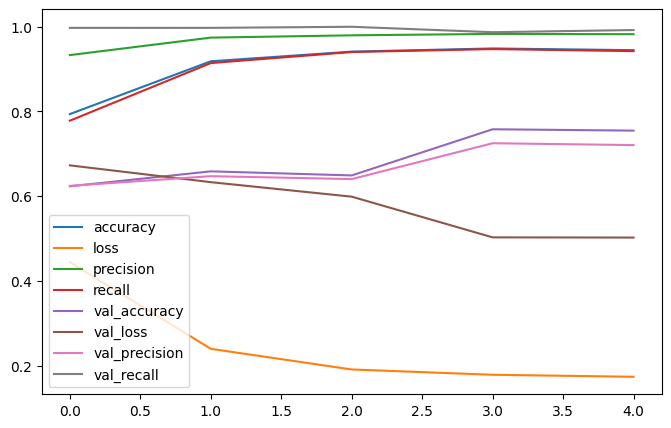

In [ ]:
pd.DataFrame(cnn_model_hist.history).plot(figsize=(8,5))

Matriz Confusão

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


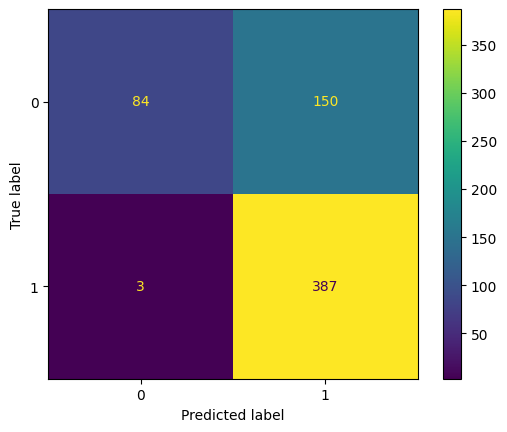

In [ ]:
predictions = cnn_model.predict(test_data)

y_pred = []
y_true = []

for image_batch, label_batch in test_data:
   y_true.append(label_batch)
   preds = cnn_model.predict(image_batch)
   y_pred.append(np.where(preds > 0.5, 1, 0))

true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.36      0.52       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.68      0.68       624
weighted avg       0.81      0.75      0.72       624

